<a href="https://colab.research.google.com/github/hchang18/non-parametric-methods/blob/main/kernel_regression_estimator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Kernel Regression Estimation
### STAT 580 Non parametric methods (Spring 2021) 
### Homework 3

Haeyoon Chang

Please import the data from data1.txt and create a nonparametric kernel estimator on $y=g(x)$.

1. Your estimator should be based on a proper selection of kernel function and bandwidth $h$.

    I used Gaussian Kernel function and, more importantly, the optimal bandwidth I chose is 0.3. I considered both bandwidths calculated using plug-in method (1.3) and cross validation method (0.3). I decided to go with the latter because it showed better fitting in the graph. See below

2. What do you observe from your result?

    Nadaraya-Watson estimator of $g(x)$ is basically the weighted average of $y$'s where the set of varying weights depends on the evaluation point $x$, kernel function, and bandwidth. Given that the number of data does not change, the bandwidth from cross validation method depends more on data itself compared to the bandwidth from plug-in method.

3. Guess what is the true $g(x)$. 

    I thought the graph should be combination of two or more functions. The data whose x is smaller than 3 were harder to guess whereas data points whose x is bigger than 3 looked like sine or cosine function.  

In [9]:
# import libraries
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import seaborn as sns
from scipy.stats import norm, expon

from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

sns.set(color_codes=True)
plt.rcParams["figure.figsize"] = (15,10)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


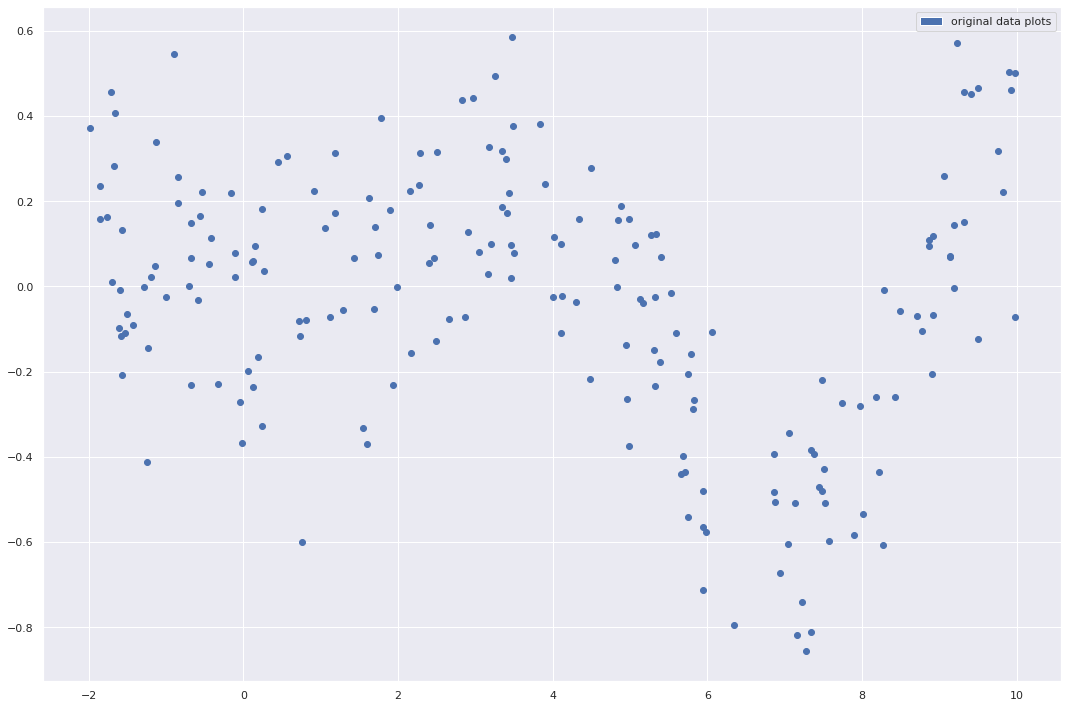

In [10]:
# ===================================================
# Import the data from data1.txt                    |
# ===================================================
from google.colab import drive
drive.mount('/content/drive')

# read in file from data1.txt
file = open("/content/drive/MyDrive/Colab Notebooks/data1.txt")
filecontent = file.readlines()
# clean up to make it into list
filecontent = [content.rstrip('\n').split(' ') for content in filecontent]
# change into array (float)
rawdata = np.array(filecontent)
data = rawdata[1:].astype(np.float)
y = data[:, 0]
x = data[:, 1]

# original data scatter plot
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(x, y)
g = ax.grid(True)
leg = mpatches.Patch(color=None, label='original data plots')
ax.legend(handles=[leg])
plt.tight_layout()
plt.show()

In [11]:
# ============================================
# Kernel Regression Estimator                |
# ============================================
def kernel_regression_estimator(data, kernel_func, bandwidth):
    """ Generate kernel regression estimator over data."""
    X = data[:, 1]
    Y = data[:, 0]
    kernels = dict()
    n = len(X)
    for d in X:
        kernels[d] = kernel_func(d, bandwidth)
    def evaluate(x):
        """Evaluate `x` using kernels above."""
        resp = list()
        weight = list()
        for d in X:
            resp.append(kernels[d](x))
        resp_sum = sum(resp) # denominator
        for i in range(n):
            weight.append(resp[i]/resp_sum)
        result = list()
        for i in range(n):
            result.append(weight[i]*Y[i])
        return sum(result)
    return (evaluate)

In [12]:
# ============================================
# Gaussian Kernel PDF                        |
# ============================================
def gaussian_pdf(x_i, bandwidth):
    """Return Gaussian kernel density estimator."""
    x_bar  = x_i
    def evaluate(x):
        """Evaluate x."""
        pdf = (np.sqrt(2*np.pi*bandwidth**2)**-1) * np.exp(-((x - x_bar)**2)/(2*bandwidth**2))
        return(pdf)
    return(evaluate)

In [13]:
# https://machinelearningmastery.com/implement-resampling-methods-scratch-python/
from random import seed
from random import randrange

def cross_validation_split(dataset, folds=10):
    dataset_split = list()
    dataset_copy = list(dataset)
    fold_size = int(len(dataset)/folds)
    for i in range(folds):
        fold = list()
        while len(fold) < fold_size:
            index = randrange(len(dataset_copy))
            fold.append(dataset_copy.pop(index))
        dataset_split.append(fold)
    return dataset_split

def bundle_test_train_set(dataset, k, test_idx):
    folds = cross_validation_split(dataset, folds=k)
    test = np.array(folds[test_idx])
    
    train = list()
    for i, x in enumerate(folds):
        if i != test_idx:
            train.extend(folds[i])
    train = np.array(train)
    return test, train

In [14]:
def estimate_bandwidth(data, kernel_function):

    num_samples = len(data[:, 0])
    y = data[:, 0]
    x = data[:, 1]
    # list of bandwidth 
    bandwidths = np.arange(0.01, 2, 0.02)

    # estimate y_hat corresponding to X
    errors = list()
    k = 10
    for h in bandwidths:
        error = 0
        folds = cross_validation_split(data, k)
        for i in range(k):
            test, train = bundle_test_train_set(data, k, i)
            estimator = kernel_regression_estimator(train, kernel_func=kernel_function, bandwidth=h)
            y_hat = [estimator(x) for x in test[:, 1]]
            error += (test[:, 0] - y_hat)**2
        errors.append(sum(error))

    errors = np.array(errors)
    # print(errors)
    # print(min(errors))
    h_opt = bandwidths[np.argmin(errors)]
    return h_opt                                                                                                        

In [15]:
# =========================================
# kernel density estimates visualizations |
# =========================================
def plot_kre(data, kernel_function):

    seed(2)

    num_samples = len(data[:, 0])
    vals = data[:, 1] # x
    xvals = np.arange(min(vals), max(vals), .01)

    # ========================================================
    # Bandwidth Selection : rule-of-thumb plugin             |
    # ========================================================
    # bandwidth estimation based on kernel function

    if "uniform_pdf" in str(kernel_function):
        sigma_hat = np.std(vals)
        R_k = 1/2
        kappa_2 = 1/3
        h_opt = (((8 * (np.pi**0.5) * R_k) / (3 * kappa_2 * num_samples))**0.2) * sigma_hat 
    
    elif "epanechnikov_pdf" in str(kernel_function):
        sigma_hat = np.std(vals)
        R_k = 3/5
        kappa_2 = 1/5
        h_opt = (((8 * (np.pi**0.5) * R_k) / (3 * kappa_2 * num_samples))**0.2) * sigma_hat 
    
    elif "gaussian_pdf" in str(kernel_function):
        sigma_hat = np.std(vals)
        R_k = 1 / (2 * (np.pi**0.5))
        kappa_2 = 1
        h_opt = (((8 * (np.pi**0.5) * R_k) / (3 * kappa_2 * num_samples))**0.2) * sigma_hat 

    # ========================================================
    # Bandwidth Selection : cross-validation                 |
    # ========================================================
    h_cv = estimate_bandwidth(data, gaussian_pdf)

    # ========================================================
    # Optimized Bandwidth visualization                      |
    # ========================================================
    fig = plt.figure()

    # bandwidth=optimal_bandwidth_plugin:
    ax4 = fig.add_subplot(2, 2, 1)
    dist_4 = kernel_regression_estimator(data, kernel_func=kernel_function, bandwidth=h_opt)
    y4 = [dist_4(i) for i in xvals]
    ax4.scatter(data[:, 1], data[:, 0])
    ax4.plot(xvals, y4)

    # bandwidth=optimal_bandwidth_crossvalidated:
    ax5 = fig.add_subplot(2, 2, 2)
    dist_5 = kernel_regression_estimator(data, kernel_func=kernel_function, bandwidth=h_cv)
    y5 = [dist_5(i) for i in xvals]
    ax5.scatter(data[:, 1], data[:, 0])
    ax5.plot(xvals, y5)

    # display gridlines 
    g4 = ax4.grid(True)
    g5 = ax5.grid(True)

    # display legend in each subplot
    leg4 = mpatches.Patch(color=None, label=f'plug-in bandwidth={h_opt}')
    leg5 = mpatches.Patch(color=None, label=f'cross-validated bandwidth={h_cv}')

    ax4.legend(handles=[leg4])
    ax5.legend(handles=[leg5])

    plt.tight_layout()
    plt.show()

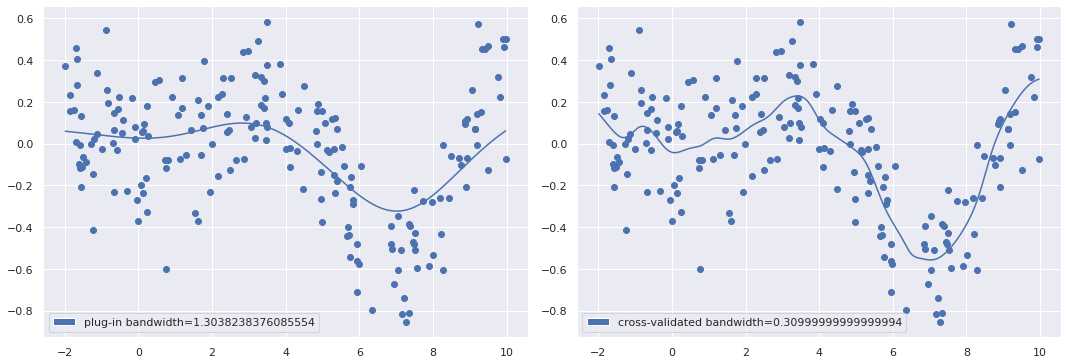

In [16]:
plot_kre(data, gaussian_pdf)

Prove the variance of estimator $\hat f'(x)$ and the expectation of $\hat g'(x)$, i.e. the first derivative of density function and mean function.

Please see the attached pdf. 